# Learning functions

In [1]:
try:
    # in colab
    import google.colab
    print('In colab, downloading LOTlib3')
    !git clone https://github.com/piantado/LOTlib3
except:
    # not in colab
    print('Not in colab!')

Not in colab!


## Imports

First we need to import a bunch of stuff:

In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [9]:
from LOTlib3.Miscellaneous import q, random, Infinity
from LOTlib3.Grammar import Grammar
from LOTlib3.DataAndObjects import FunctionData, Obj
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.Hypotheses.Likelihoods.BinaryLikelihood import BinaryLikelihood
from LOTlib3.Eval import primitive
from LOTlib3.Miscellaneous import qq
from LOTlib3.TopN import TopN
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler

In [3]:
from math import log

## The task

The aim here is to define a language that recovers the explicit form for a mathematical function most likely to have generated a certain set of input-output pairs. 

For instance, to start with we might want: addition, product, power, log, exp.

If we want to make it fancier, we can add recursion up to a level (which allows us to do e.g. series)
    
> __**AIMS**__ 
> - Pick a set of mathematical primitives that seem likely
> - Define a grammar
> - Define likelihood, e.g., sum of squares minimization
> - Run inference algo on the example datasets below!

Copying data from other notebook:

In [71]:
f1 = np.array([
    [ 1.        ,  0.96693628],
    [ 1.65517241,  0.44488931],
    [ 2.31034483,  0.11111997],
    [ 2.96551724, -0.05388751],
    [ 3.62068966, -0.08770159],
    [ 4.27586207, -0.34701368],
    [ 4.93103448, -0.5312597 ],
    [ 5.5862069 , -0.56654964],
    [ 6.24137931, -0.98309806],
    [ 6.89655172, -0.87024759],
    [ 7.55172414, -1.02468311],
    [ 8.20689655, -1.07690071],
    [ 8.86206897, -1.3229659 ],
    [ 9.51724138, -1.26628302],
    [10.17241379, -1.26076366],
    [10.82758621, -1.29232939],
    [11.48275862, -1.47545188],
    [12.13793103, -1.53730544],
    [12.79310345, -1.72121669],
    [13.44827586, -1.59430107],
    [14.10344828, -1.6440229 ],
    [14.75862069, -1.74346587],
    [15.4137931 , -1.89063419],
    [16.06896552, -1.87860771],
    [16.72413793, -1.73337155],
    [17.37931034, -1.74285824],
    [18.03448276, -1.82462328],
    [18.68965517, -2.13664592],
    [19.34482759, -1.87158473],
    [20.        , -1.96221768]
])

f2 = np.array([
    [1.00000000e+00, 3.71191585e+00],
    [1.65517241e+00, 9.24602588e+00],
    [2.31034483e+00, 1.71111810e+01],
    [2.96551724e+00, 2.74461376e+01],
    [3.62068966e+00, 4.04248405e+01],
    [4.27586207e+00, 5.58883272e+01],
    [4.93103448e+00, 7.39602616e+01],
    [5.58620690e+00, 9.45716098e+01],
    [6.24137931e+00, 1.17768463e+02],
    [6.89655172e+00, 1.43745608e+02],
    [7.55172414e+00, 1.72014815e+02],
    [8.20689655e+00, 2.03113066e+02],
    [8.86206897e+00, 2.36586296e+02],
    [9.51724138e+00, 2.72592478e+02],
    [1.01724138e+01, 3.11500578e+02],
    [1.08275862e+01, 3.52680831e+02],
    [1.14827586e+01, 3.96347343e+02],
    [1.21379310e+01, 4.42937224e+02],
    [1.27931034e+01, 4.91952665e+02],
    [1.34482759e+01, 5.43415913e+02],
    [1.41034483e+01, 5.97790718e+02],
    [1.47586207e+01, 6.54449584e+02],
    [1.54137931e+01, 7.13693393e+02],
    [1.60689655e+01, 7.75636386e+02],
    [1.67241379e+01, 8.39996211e+02],
    [1.73793103e+01, 9.07024122e+02],
    [1.80344828e+01, 9.76727694e+02],
    [1.86896552e+01, 1.04889184e+03],
    [1.93448276e+01, 1.12381860e+03],
    [2.00000000e+01, 1.20102847e+03]
])


f3 = np.array([
    [   1.        ,    3.4938151 ],
    [   1.65517241,    5.44628788],
    [   2.31034483,    6.53998577],
    [   2.96551724,    7.67421996],
    [   3.62068966,    7.89516258],
    [   4.27586207,    8.02252067],
    [   4.93103448,    7.55957521],
    [   5.5862069 ,    6.68554562],
    [   6.24137931,    5.49661335],
    [   6.89655172,    3.78650889],
    [   7.55172414,    1.76357834],
    [   8.20689655,   -0.95288503],
    [   8.86206897,   -3.56660826],
    [   9.51724138,   -7.30943747],
    [  10.17241379,  -11.0152518 ],
    [  10.82758621,  -15.41306886],
    [  11.48275862,  -20.02607231],
    [  12.13793103,  -25.05703701],
    [  12.79310345,  -30.66109506],
    [  13.44827586,  -36.58291196],
    [  14.10344828,  -43.09300853],
    [  14.75862069,  -49.80759178],
    [  15.4137931 ,  -57.20869912],
    [  16.06896552,  -64.76773707],
    [  16.72413793,  -72.90556438],
    [  17.37931034,  -81.42918673],
    [  18.03448276,  -90.50159589],
    [  18.68965517,  -99.98277275],
    [  19.34482759, -109.61216676],
    [  20.        , -120.07684039]
])

Displaying data:

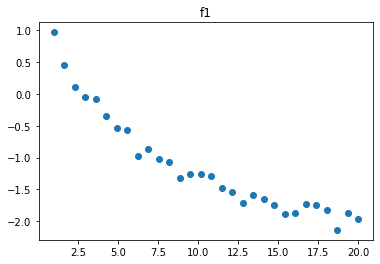

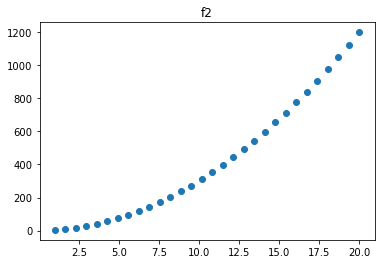

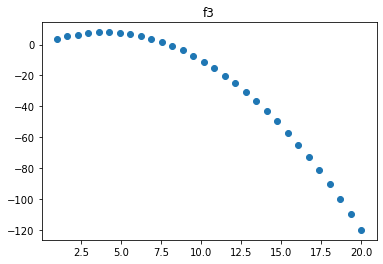

In [73]:
for i, f in enumerate([f1, f2, f3]):
    plt.scatter(*f.T)
    plt.title(f'f{i+1}')
    plt.show()
    print('\n')

## Define the grammar

In [74]:
@primitive
def log_(s):
    return log(s)

In [31]:
g = Grammar(start='S')

g.add_rule('S', '(%s+%s)', ['S', 'S'], 1.)
g.add_rule('S', '(-%s)', ['S'], 1.)
g.add_rule('S', '(%s/%s)', ['S', 'S'], 1.)
g.add_rule('S', '(%s*%s)', ['S', 'S'], 1.)
g.add_rule('S', '(%s**%s)', ['S', 'S'], 1.)
g.add_rule('S', 'log_', ['S'], 1.)

for i in range(10):
    g.add_rule('S', str(i), None, 1/(i+1))

g.add_rule('S', 'x', None, 3)

S -> x	w/ p=3.0

In [5]:
g.generate()

6

## Defining hypothesis

In [8]:
def normal_density(x, mu, sigma):
    normalization = 1/(2 * sigma**2 * np.pi)**(1/2)
    return np.exp(-(x-mu)**2 / (2*sigma**2))

In [75]:
class FunctionHyp(LOTHypothesis):
    
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(
            self, 
            grammar=g, 
            display='lambda x: %s',
            **kwargs
        )   
            
    def compute_single_likelihood(self, datum):
        """
        NOTE: cases where we need to return prob 0: 
        - division by 0
        - log of 0
        - complex part is not 0
        - overflow in calculation
        """
        try:
            y_hat = self(datum.input[0])
            
            if type(y_hat) is complex:
                return -Infinity
            
            if abs(y_hat - datum.output) > 10e10:
                return -Infinity
            
            logprob = np.log(
                normal_density(
                    datum.output,
                    y_hat, 
                    1.
                )
            )
            return logprob
        
        except (ValueError, ZeroDivisionError, TypeError, OverflowError):
            return -Infinity

## Fitting hypothesis to the data

In [64]:
xs = np.linspace(-10, 10, 100)
ys = xs**3 + np.random.normal(size=len(xs))

data = [
    FunctionData(input=[x], output=y)
    for x,y in zip(xs, ys)
]

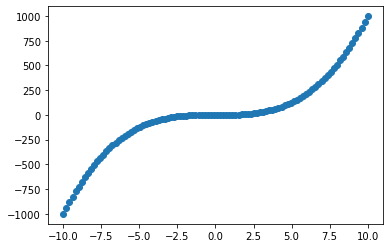

In [65]:
plt.scatter(xs, ys)

In [ ]:
topn = TopN(10)
h = FunctionHyp()
for h1 in MetropolisHastingsSampler(h, data, steps=10000):
    topn << h1

In [78]:
for i in topn:
    print(
        np.exp(i.posterior_score), 
        np.exp(i.prior), 
        np.exp(i.likelihood), 
        i
    )

4.2242075264123894e-32 1.5524472545339268e-06 2.7209990639460335e-26 lambda x: ((x/1)**3)
4.2242075264123894e-32 1.5524472545339268e-06 2.7209990639460335e-26 lambda x: ((x**1)**3)
4.2242075264123894e-32 1.5524472545339268e-06 2.7209990639460335e-26 lambda x: (x**(1*3))
8.448415052824795e-32 3.1048945090678596e-06 2.7209990639460335e-26 lambda x: ((x+0)**3)
8.448415052824795e-32 3.1048945090678596e-06 2.7209990639460335e-26 lambda x: ((0+x)**3)
8.448415052824795e-32 3.1048945090678596e-06 2.7209990639460335e-26 lambda x: ((-(-x))**3)
8.448415052824795e-32 3.1048945090678596e-06 2.7209990639460335e-26 lambda x: (x**(0+3))
3.379366021130363e-31 1.2419578036271418e-05 2.720999063946381e-26 lambda x: ((x**2)*x)
3.0414294190173123e-30 0.00011177620232644284 2.720999063946381e-26 lambda x: ((x*x)*x)
1.2022118580228194e-29 0.0004418273692014243 2.7209990639460335e-26 lambda x: (x**3)


## Recovering fs above

### f1

In [80]:
data1 = [
    FunctionData(input=[x], output=y)
    for x,y in f1
]

In [ ]:
topn = TopN(10)
h = FunctionHyp()
for h1 in MetropolisHastingsSampler(h, data1, steps=10000):
    topn << h1

In [85]:
for i in topn:
    print(
        np.exp(i.posterior_score), 
        np.exp(i.prior), 
        np.exp(i.likelihood), 
        i
    )

1.6260504736405028e-08 2.1819313570058165e-08 0.7452344769781715 lambda x: (-log_(((x+0)/3)))
2.032154962684583e-08 3.4704253186746956e-07 0.05855636632632202 lambda x: (-log_((2**log_(x))))
2.1194894870977892e-08 1.3014094945030098e-07 0.16286107455418494 lambda x: (-log_((x/log_(7))))
3.400796156783955e-08 4.363862714011626e-08 0.7793086949927576 lambda x: (-log_(((x+x)/5)))
3.426163230687842e-08 1.1568084395582305e-07 0.2961737754952965 lambda x: (-log_((x/log_(8))))
4.582103973987705e-08 1.0411275956024088e-07 0.44010974191270397 lambda x: (-log_((x/log_(9))))
2.2696964844663247e-07 2.4839156072542857e-06 0.09137574875078952 lambda x: (-log_((x/4)))
2.9464772005047395e-07 0.0035136964406253983 8.38569082530163e-05 lambda x: (-1)
8.771111897518796e-07 4.139859345423809e-06 0.21186980439841194 lambda x: (-log_((x/2)))
2.3138744355375844e-06 3.1048945090678596e-06 0.7452344769781715 lambda x: (-log_((x/3)))


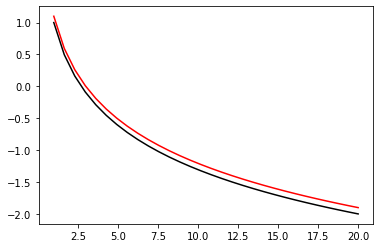

In [86]:
x = np.linspace(1, 20, 30)
y = 1 - np.log(x)
y_hat = -np.log(x/3)

plt.plot(x, y, color='black')
plt.plot(x, y_hat, color='red')

### f2

In [87]:
data2 = [
    FunctionData(input=[x], output=y)
    for x,y in f2
]

In [ ]:
topn = TopN(10)
h = FunctionHyp()
for h1 in MetropolisHastingsSampler(h, data2, steps=10000):
    topn << h1

It didn't quite manage to recover it! Maybe try running more samples.

In [92]:
for i in topn:
    print(
        np.exp(i.posterior_score), 
        np.exp(i.prior), 
        np.exp(i.likelihood), 
        i
    )

0.0 5.20563797801204e-07 0.0 lambda x: (log_((1/0))+x)
0.0 6.584771388429113e-08 0.0 lambda x: (log_(((x*x)/0))+x)
0.0 3.123382786807228e-06 0.0 lambda x: (log_((x/0))+x)
0.0 3.47042531867469e-07 0.0 lambda x: (log_((2/0))+x)
0.0 1.041127595602408e-06 0.0 lambda x: (log_((2/x))+x)
0.0 0.00014815275212236306 0.0 lambda x: (log_(0)+x)
0.0 3.8791096257899265e-11 0.0 lambda x: (log_(0)+(log_((x**(x*x)))**0))
0.0 0.0 0.0 lambda x: (log_((-(9+(log_((((1+x)**(-x))+(-(log_((x**((log_(((log_(1)/1)+x))**(0/(-(-(x**x)))))+(((log_(x)**0)+(log_(2)/6))/x))))*7))))/6))))+(log_((x**(x*x)))**0))
0.0 0.0 0.0 lambda x: (log_((-(9+(log_((((1+x)**(-x))+(-(log_((x**((log_(((log_(1)/1)+x))**(0/(-(-(x**x)))))+(((log_(x)**0)+(x/6))/x))))*7))))/6))))+(log_((x**(x*x)))**0))
0.0 0.0 0.0 lambda x: (log_((-(9+(log_((((1+x)**(-x))+(-(log_((x**((log_(x)**(0/(-(-(x**x)))))+(((log_(x)**0)+(x/6))/x))))*7))))/6))))+(log_((x**(x*x)))**0))


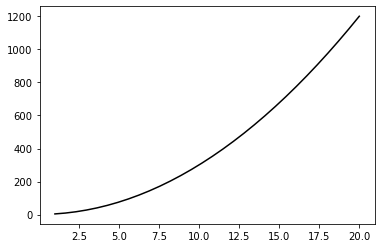

In [93]:
x = np.linspace(1, 20, 30)
y =  1 + 3 * x**2
# y_hat = -np.log(x/3)

plt.plot(x, y, color='black')
# plt.plot(x, y_hat, color='red')

### f3

In [94]:
data3 = [
    FunctionData(input=[x], output=y)
    for x,y in f3
]

In [ ]:
topn = TopN(10)
h = FunctionHyp()
for h1 in MetropolisHastingsSampler(h, data3, steps=10000):
    topn << h1

In [96]:
for i in topn:
    print(
        np.exp(i.posterior_score), 
        np.exp(i.prior), 
        np.exp(i.likelihood), 
        i
    )

5.5633e-319 4.9272858943829863e-23 1.1290769819862322e-296 lambda x: (((-x)/5)*(x+log_((log_(9)**((-(3*(3+1)))+x)))))
1.3025651072045499e-137 2.4188997377983393e-26 5.384948730409537e-112 lambda x: (((-x)/5)*(x+log_((((1*2)+1)**((-(3*(3+1)))+x)))))
9.962314620286416e-134 5.8747019205416375e-27 1.6957991664993362e-107 lambda x: (((-x)/5)*(x+log_((4**((-(3*4))+(x/((x/x)+(-(-0)))))))))
3.0764761194029836e-133 1.8141748033487692e-26 1.6957991664993362e-107 lambda x: (((-x)/5)*(x+log_((((1*3)+1)**((-(3*(3+1)))+x)))))
7.004534788680389e-131 4.1305214243854454e-24 1.6957991664993362e-107 lambda x: (((-x)/5)*(x+log_((((1*3)+1)**((-(3*4))+x)))))
3.18959131822274e-128 1.8808779843942615e-21 1.6957991664993362e-107 lambda x: (((-x)/5)*((-(-x))+log_((4**((-(3*4))+x)))))
4.538797491645367e-126 2.676494706041661e-19 1.6957991664993362e-107 lambda x: (((-x)/5)*(x+log_((4**((-(3*4))+x)))))
1.4552175436922316e-58 3.9418287155063925e-23 3.69173205818834e-36 lambda x: (((-x)/5)*(x+log_((4**((-(3*4))+(x/l

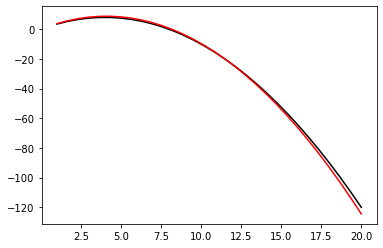

In [98]:
x = np.linspace(1, 20, 30)
y =   4 * x - 0.5 * x**2
y_hat = (((-x)/5)*(x+np.log((6**((-(3*4))+(x/log_(3)))))))

plt.plot(x, y, color='black')
plt.plot(x, y_hat, color='red')